In [1]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

In [2]:
class AutoEncoder(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.input_shape = kwargs["input_shape"]
        # number of hidden units in first hidden layer
        self.n_units = kwargs["n_units"]
        self.half_units = kwargs["n_units"] // 2
        
        self.encoder = torch.nn.Sequential(
            # Linear(): Initiate a linear function theta*x + b
            nn.Linear(in_features=self.input_shape, out_features=self.n_units),
            torch.nn.ReLU(),
            nn.Linear(in_features=self.n_units, out_features=self.half_units),
        )
        self.decoder = torch.nn.Sequential(
            nn.Linear(in_features=self.half_units, out_features=self.n_units),
            torch.nn.ReLU(),
            nn.Linear(in_features=self.n_units, out_features=self.input_shape),
            torch.nn.Sigmoid()
        )
    
    # x denotes features
    def forward(self, X):
        encode = self.encoder(X)
        decode = self.decoder(encode)
        return decode

In [3]:
# 10,000 samples, 30x30 matrices
is_pca = False
data = np.ndarray(shape=(10000,30,30))
n_features = data.shape[1] * data.shape[2]

for i in range(10000):
    path = f'data/jet_matrices/sample{i+1}.dat'
    sample = np.loadtxt(path, unpack = True)
    data[i] = sample

print("Done loading data.")

Done loading data.


In [4]:
# Flatten data and convert to Torch Tensor

# 10,000 samples, 900 features
X = np.ndarray(shape=(10000, n_features))
for i, sample in enumerate(data):
    flat = sample.flatten()
    X[i] = flat
    #print(X[i])

X = torch.from_numpy(X)
# Convert all scalars to floats. May affect training behavior (ie. reconstructions made of non-binary scalar values)
X = X.float()
print(X)

tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.]])


## PCA

In [ ]:
def de_correlate_data(X):
    X_pert = np.copy(X)
    i = 0
    for col in X.T:
        #print(col)
        X_pert[:,i] = np.random.permutation(col)
        #print(X_pert[:,i])
        i += 1
        
    return X_pert

# # function demo
# z = np.array([[1,2,3],[4,5,6],[7,8,9]])
# #z = np.array([[0,1,0],[1,0,1],[1,1,1]])
# print(z)
# X_pert = de_correlate_data(z)
# print(X_pert)

In [ ]:
# Plot cumulative explained variance w.r.t. number of components

def pca_run(X):
    pca = PCA(n_components=0.95).fit(X)

    #% matplotlib inline
    import matplotlib.pyplot as plt
    plt.rcParams["figure.figsize"] = (12,6)

    fig, ax = plt.subplots()
    y = np.cumsum(pca.explained_variance_ratio_)
    # n_components = number of components needed to reach cum. variance threshold
    n_components = y.size
    xi = np.arange(1, n_components+1, step=1)

    plt.ylim(0.0,1.1)
    plt.plot(xi, y, marker='o', linestyle='--', color='b')

    plt.xlabel('Number of Components')
    #change from 0-based array index to 1-based human-readable label
    plt.xticks(np.arange(0, n_components+1, step=1))
    plt.ylabel('Cumulative variance (%)')
    plt.title('The Number of Components Needed to Explain Variance')

    plt.axhline(y=0.95, color='r', linestyle='-')
    plt.axhline(y=0.8, color='g', linestyle='-')
    plt.axhline(y=0.9, color='b', linestyle='-')
    plt.text(0, 0.915, '95% cut-off threshold', color = 'red', fontsize=13)
    plt.text(24, 0.85, '90% cut-off threshold', color = 'blue', fontsize=13)
    plt.text(12, 0.75, '80% cut-off threshold', color = 'green', fontsize=13)

    ax.grid(axis='x')
    plt.show()

# Run with original data.
pca_run(X.numpy())

# Run with permutated data.
# De-correlates features, so performing worse than original data indicates
# existence of correlation in the original data's features.
X_pert = de_correlate_data(X)
pca_run(X_pert)

In [ ]:
plt.rcParams["figure.figsize"] = (12,6)
fig, ax = plt.subplots()
plt.bar(xi, pca.explained_variance_ratio_, width=0.4)
plt.ylabel("Percent of Total Variance")
plt.xlabel("Principal Component")
plt.title("Significance of Each Principal Component Towards Variance ")

In [ ]:
# PCA

# Toggle to indicate to training that PCA is in use
is_pca = True
# -- DEFINE NUMBER OF COMPONENTS HERE --
n_components = 5

pca = PCA(n_components=n_components).fit(X.numpy())

print(X)
# If fails, re-run "Flatten data..." cell
X_pca = pca.fit_transform(X)
X_pca = torch.from_numpy(X_pca)
# Convert all scalars to floats. May affect training behavior (ie. reconstructions made of non-binary scalar values)
X_pca = X_pca.float()
# Replace former n_features with number of components
n_features = X_pca.shape[1]

## Training

In [5]:
# Changes X based on whether PCA was used
if is_pca:
    X_2 = X_pca
else:
    X_2 = X

batch_size = 32
lr = 1e-3
train_size = int(0.8 * len(X_2))
test_size = len(X_2) - train_size

In [6]:
# Initate data loaders

train, test = torch.utils.data.random_split(X_2, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(
    train, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False
)

test_loader = torch.utils.data.DataLoader(
    test, batch_size=batch_size, shuffle=False, num_workers=0
)

In [ ]:
# # USE FOR MNIST ONLY

# # Use gpu if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(device)

# # Define model
# model = AutoEncoder(input_shape=n_features, n_units=32).to(device)

# # Define Adam optimizer
# optimizer = optim.Adam(model.parameters(), lr=lr)

# # Mean-squared error loss
# criterion = nn.MSELoss()

# input_shape = 784
# # Convert numpy array to tensor
# transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

# # Define 
# train = torchvision.datasets.MNIST(
#     root="~/torch_datasets", train=True, transform=transform, download=True
# )

# test = torchvision.datasets.MNIST(
#     root="~/torch_datasets", train=False, transform=transform, download=True
# )

# train_loader = torch.utils.data.DataLoader(
#     train, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True
# )

# test_loader = torch.utils.data.DataLoader(
#     test, batch_size=batch_size, shuffle=False, num_workers=4
# )

In [ ]:
def CustomCrossEntropy(outputs, targets):
    pass

In [7]:
# Training

# Use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Define model
model = AutoEncoder(input_shape=n_features, n_units=32).to(device)

# Define Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

# Mean-squared error loss
criterion = nn.MSELoss()
#criterion = nn.BCELoss()

# Reset model state if previously trained
torch.manual_seed(1)
def weights_init(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)
        print("existing instance")

model.apply(weights_init)

print("Training...")

epochs=5
for epoch in range(epochs):
    loss = 0
    for i, batch in enumerate(train_loader, 0):
        
        # reshape mini-batch data from [batch_size, 30, 30] to [batch_size, 900]
        # load it to the active device
        batch = batch
        batch = batch.view(-1, n_features).to(device)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = model(batch)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(train_loader)
    
    # display the epoch training loss
    print("Epoch : {}/{}, Training Loss = {:.6f}".format(epoch + 1, epochs, loss))

cuda
existing instance
existing instance
existing instance
existing instance
Training...
Epoch : 1/5, Training Loss = 0.031352
Epoch : 2/5, Training Loss = 0.010028
Epoch : 3/5, Training Loss = 0.005474
Epoch : 4/5, Training Loss = 0.004125
Epoch : 5/5, Training Loss = 0.003850


In [ ]:
# PATH = './cifar_net.pth'
# torch.save(net.state_dict(), PATH)

## Testing

In [8]:
# Testing

# Decoupled into three lists due to issue with placing torch tensors into multidimensional lists
batches = []
recons = []
test_losses = []

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    i = 1
    for batch in test_loader:
        batch = batch.view(-1, n_features).to(device)
        reconstructions = model(batch)
        # Reconstruction loss
        test_loss = criterion(reconstructions, batch)
        # Store samples, predictions, and loss for visualization purposes
        batches.append(batch)
        recons.append(reconstructions)
        test_losses.append(test_loss)
        print(f'Batch {i}: {test_loss.item()}')
        i += 1

test_loss_avg = sum(test_losses) / len(test_losses)
print(f"Average Test Reconstruction Loss: {test_loss_avg}")

Batch 1: 0.005191343370825052
Batch 2: 0.0033031979110091925
Batch 3: 0.004492554347962141
Batch 4: 0.004209436941891909
Batch 5: 0.002570665441453457
Batch 6: 0.003809648333117366
Batch 7: 0.004432089161127806
Batch 8: 0.004391775466501713
Batch 9: 0.0035609775222837925
Batch 10: 0.0037319730035960674
Batch 11: 0.0031468523666262627
Batch 12: 0.0035347426310181618
Batch 13: 0.004182823002338409
Batch 14: 0.0038374410942196846
Batch 15: 0.0033009983599185944
Batch 16: 0.003664860501885414
Batch 17: 0.0041441535577178
Batch 18: 0.004119107965379953
Batch 19: 0.002715512178838253
Batch 20: 0.004345372319221497
Batch 21: 0.002521837130188942
Batch 22: 0.0034535059239715338
Batch 23: 0.00455361558124423
Batch 24: 0.005932388361543417
Batch 25: 0.0032879128120839596
Batch 26: 0.0038935847114771605
Batch 27: 0.003332948312163353
Batch 28: 0.0050183129496872425
Batch 29: 0.003165427828207612
Batch 30: 0.004917453043162823
Batch 31: 0.00327743380330503
Batch 32: 0.0038395309820771217
Batch 33:

## Visualization

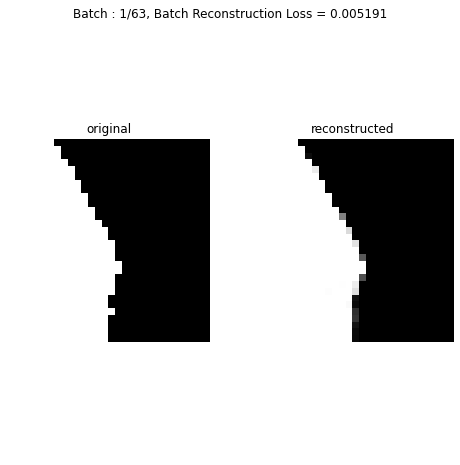

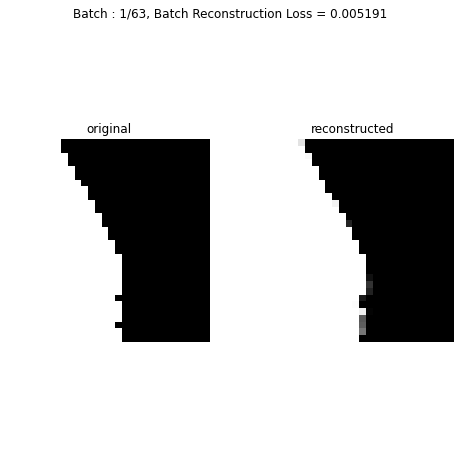

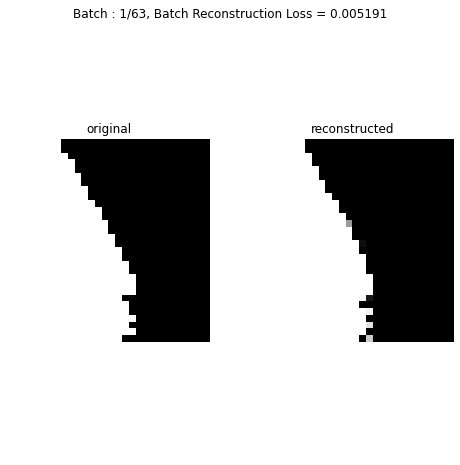

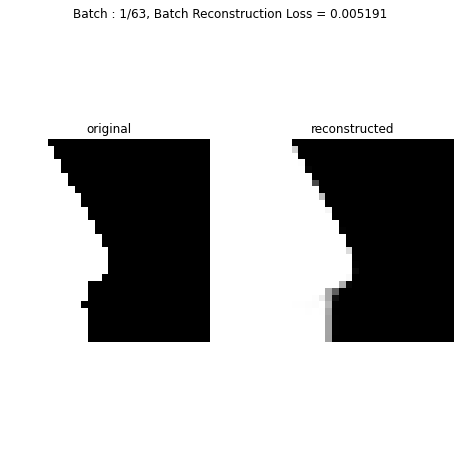

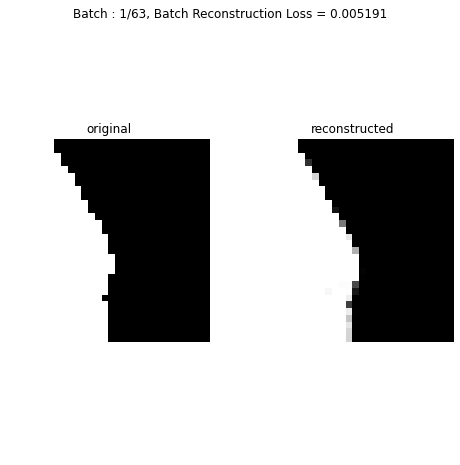

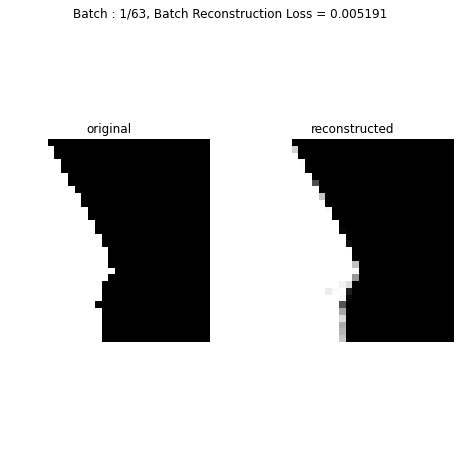

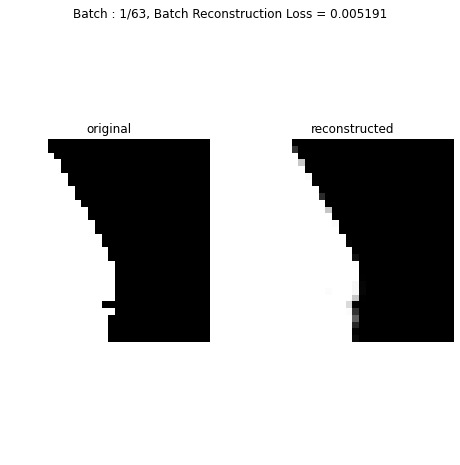

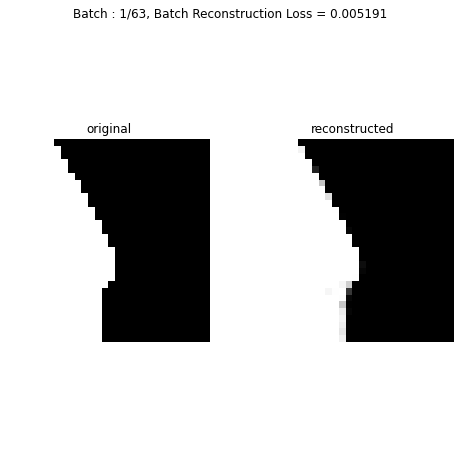

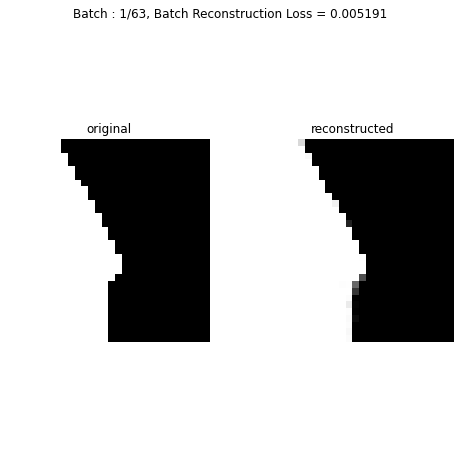

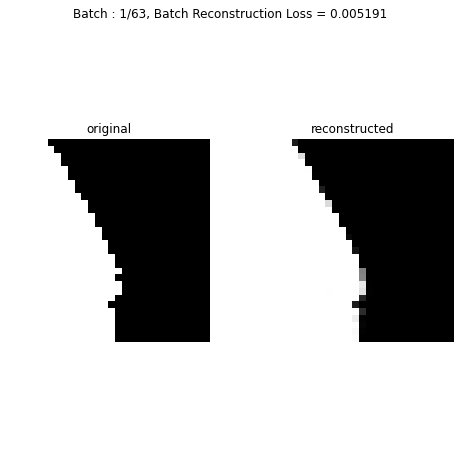

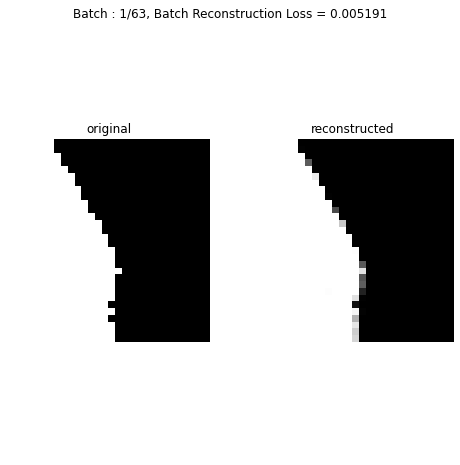

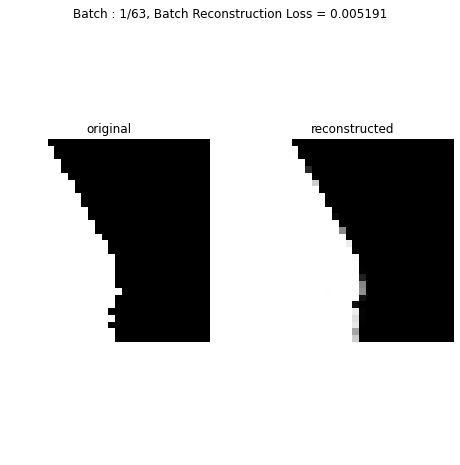

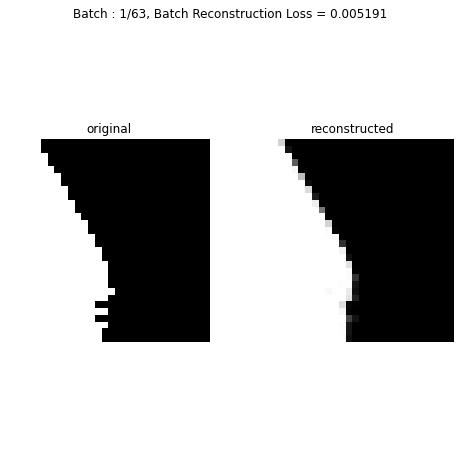

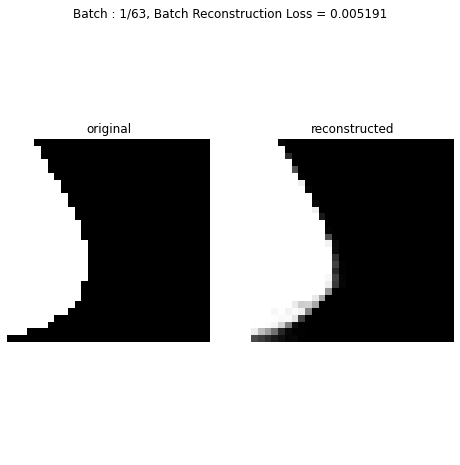

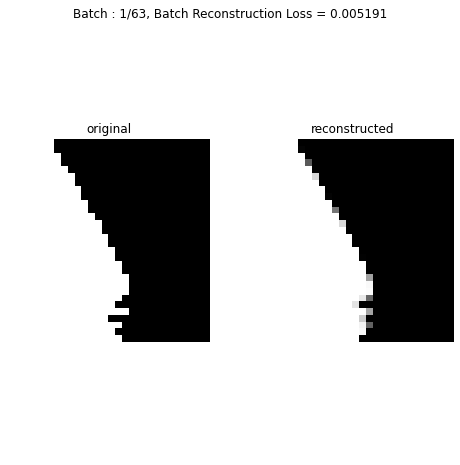

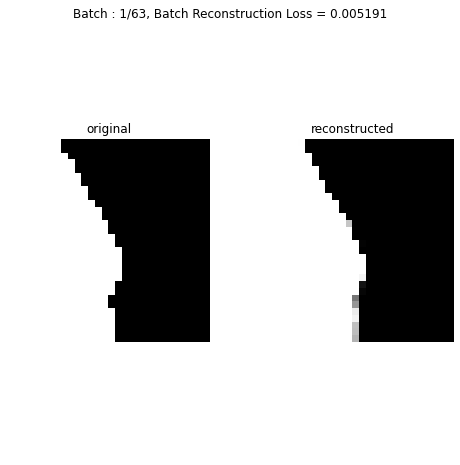

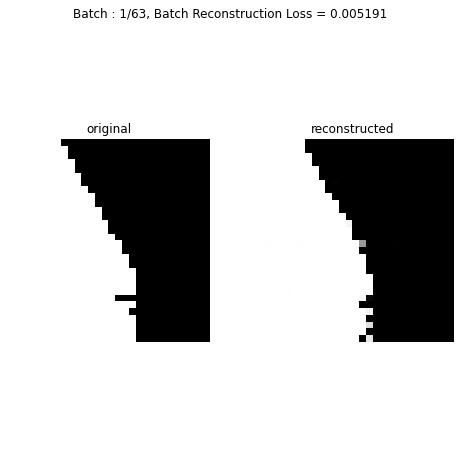

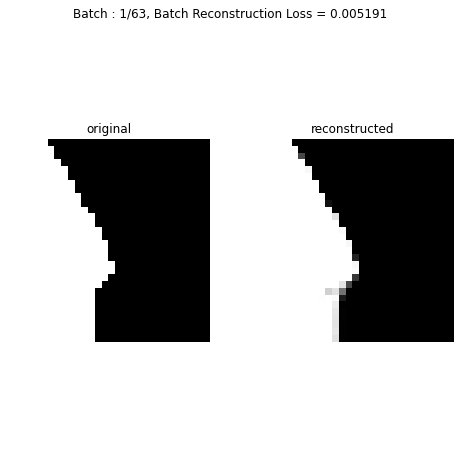

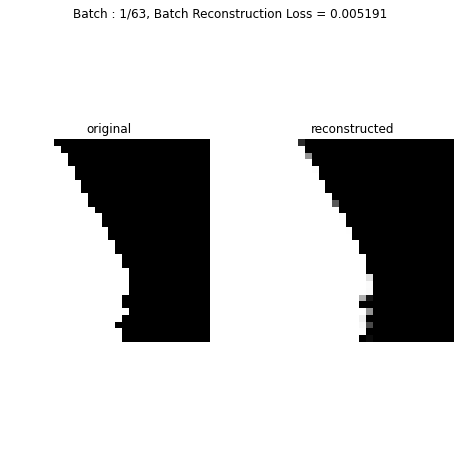

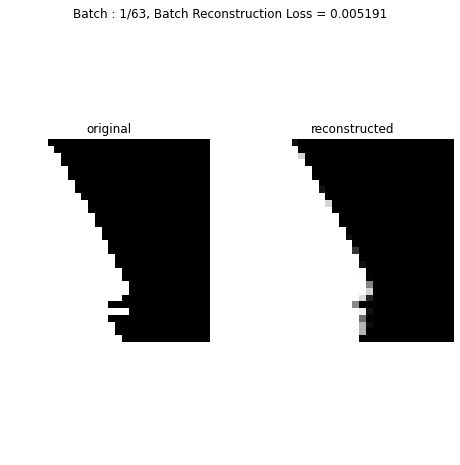

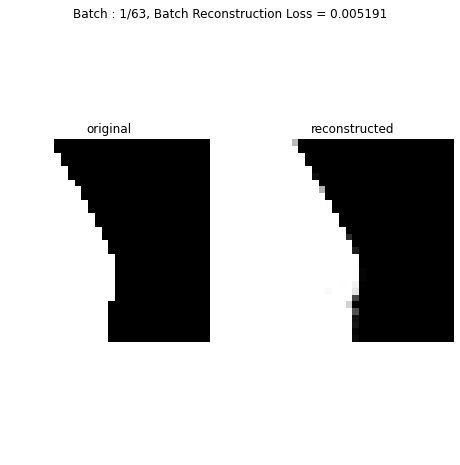

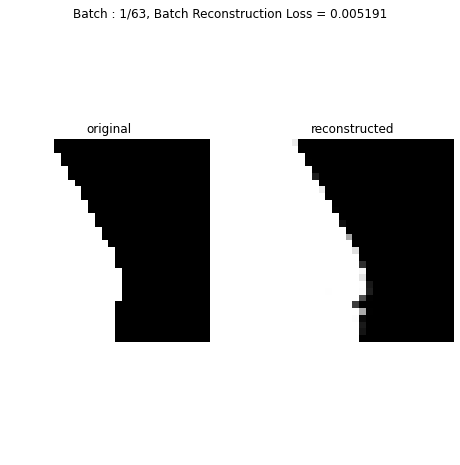

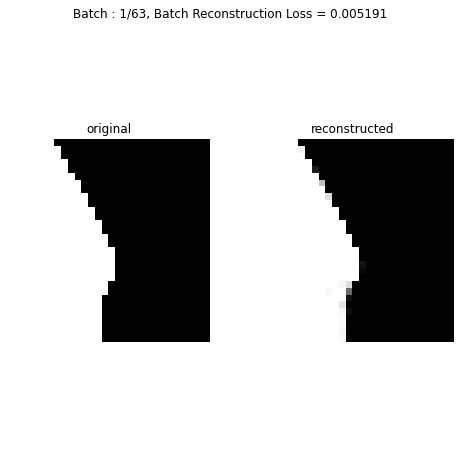

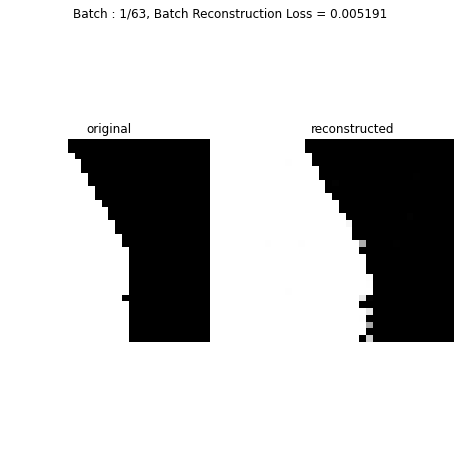

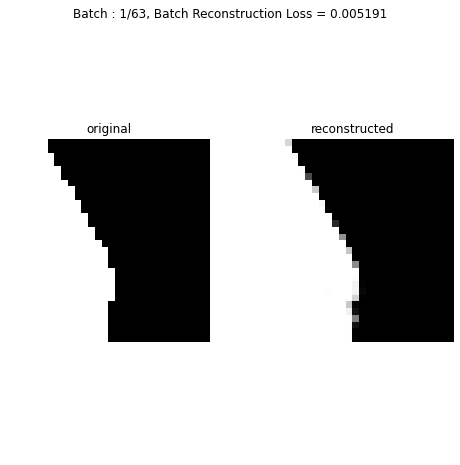

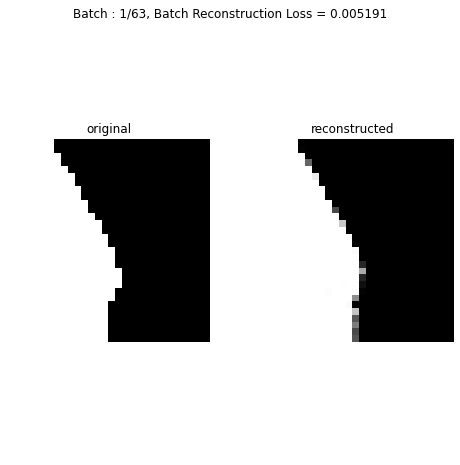

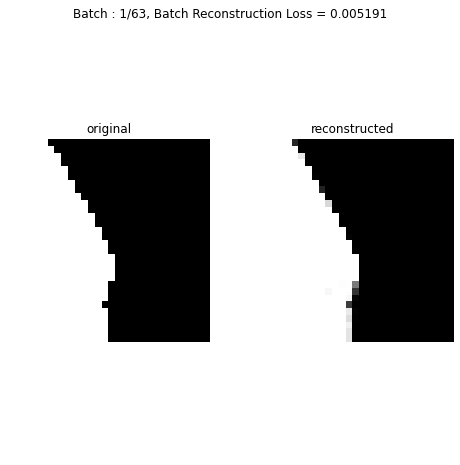

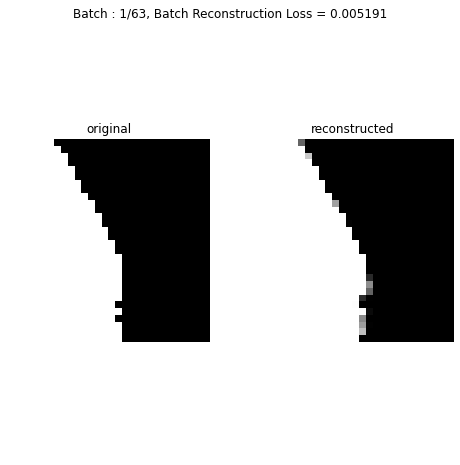

KeyboardInterrupt: 

In [9]:
# Visualization

for i in range(len(recons)):
    loss = test_losses[i]
    batch = batches[i]
    reconstructions = recons[i]
    # Iterate through all examples in ith batch
    for j in range(len(batch)):
        # Reshape original example for plotting back into 30x30
        # or keep as vector of components if using PCA.
        if is_pca:
            original = batch[j].reshape(1, n_features)
        else:
            original = batch[j].reshape(data.shape[1], data.shape[2])
        original = original.cpu()
        # Reshape reconstructed example for plotting
        # or keep as vector of components if using PCA.
        if is_pca:
            reconstruction = reconstructions[j].reshape(1, n_features)
        else:
            reconstruction = reconstructions[j].reshape(data.shape[1], data.shape[2])
        reconstruction = reconstruction.cpu()
        
        fig = plt.figure(figsize=(8, 8))
        plt.title("Batch : {}/{}, Batch Reconstruction Loss = {:.6f}".format(i+1, len(recons), loss))
        plt.axis('off')
        # display original
        fig.add_subplot(1, 2, 1)
        plt.imshow(original)
        plt.axis('off')
        plt.title("original")
        plt.gray()
        
        # fig.get_xaxis().set_visible(False)
        # fig.get_yaxis().set_visible(False)

        # display reconstruction
        fig.add_subplot(1, 2, 2)
        plt.imshow(reconstruction)
        plt.axis('off')
        plt.title("reconstructed")
        plt.gray()
        # fig.get_xaxis().set_visible(False)
        # fig.get_yaxis().set_visible(False)
        plt.show()